# Part 1: Building bot using RASA Core

### Installation
First we will install Rasa Core on the server running this notebook. In this step our bot will not be able to understand the natural language for intents yet.
**Running the cell below will take a couple of minutes to complete.**

In [0]:
!pip install rasa_core==0.9.6;
!echo "Europe/Berlin" > /etc/timezone

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

!pip install rasa_core_sdk

     |████████████████████████████████| 133kB 9.2MB/s 
     |████████████████████████████████| 49.1MB 1.2MB/s 
     |████████████████████████████████| 665kB 43.7MB/s 
     |████████████████████████████████| 61kB 27.3MB/s 
     |████████████████████████████████| 1.0MB 44.1MB/s 
     |████████████████████████████████| 133kB 53.2MB/s 
     |████████████████████████████████| 71kB 29.7MB/s 
     |████████████████████████████████| 71kB 32.6MB/s 
     |████████████████████████████████| 307kB 52.5MB/s 
     |████████████████████████████████| 51kB 28.1MB/s 
     |████████████████████████████████| 4.9MB 43.1MB/s 
     |████████████████████████████████| 3.1MB 49.0MB/s 
     |████████████████████████████████| 122kB 44.3MB/s 
     |████████████████████████████████| 81kB 28.1MB/s 
     |████████████████████████████████| 204kB 52.6MB/s 
     |████████████████████████████████| 81kB 32.8MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 174kB 52.0MB/s 

### Writing Stories

A good place to start is by writing a few stories. These are example conversations that Rasa Core will learn from. 

The format works like this:

A story starts with `##`and we will mention a name for each story.. 
lines that start with  **`*`** are messages/queries sent by the user. Although we  don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. 
Lines that start with `-` are *actions* taken by our bot. In our thesis, almost all actions are customised actions which are either used to send some message or response, used to all another action, or used to calculate some or the other statistics for user's data.

In [0]:
stories_md = """   
## path mean        
* upload_file
  - action_uploadFile
  - slot{"column_choose":"column"}
  - slot{"file_name":"file"}
* select_stat
  - action_stat
* calculate_mean{"mean":"mean"}
  - action_cal_mean
* affirm
  - utter_affirm
* goodbye
  - action_bye
    
## path median
* upload_file
  - action_uploadFile
  - slot{"column_choose":"column"}
  - slot{"file_name":"file"}
* select_stat
  - action_stat
* calculate_median{"median":"median"}
  - action_cal_median
* affirm
  - utter_affirm
* goodbye
  - action_bye
  
## path sd
* upload_file
  - action_uploadFile
  - slot{"column_choose":"column"}
  - slot{"file_name":"file"}
* select_stat
  - action_stat
* calculate_sd{"sd":"sd"}
  - action_cal_sd
* affirm
  - utter_affirm
* goodbye
  - action_bye

## path Harmonic mean
* upload_file
  - action_uploadFile
  - slot{"column_choose":"column"}
  - slot{"file_name":"file"}
* select_stat
  - action_stat
* calculate_Hmean{"hmean":"hmean"}
  - action_cal_Hmean
* affirm
  - utter_affirm
* goodbye
  - action_bye

## path sd
* upload_file
  - action_uploadFile
  - slot{"column_choose":"column"}
  - slot{"file_name":"file"}
* select_stat
  - action_stat
* calculate_Pvariance{"pvar":"pvar"}
  - action_cal_PVariance
* affirm
  - utter_affirm
* goodbye
  - action_bye


"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that your bot lives in. We list all of the intents and actions that comes in our story file. 
In this file we also can write template or sample messages which our bot can send back as response.

In [0]:
domain_yml = """
intents:
  - goodbye
  - calculate_median
  - calculate_mean
  - calculate_sd
  - calculate_Hmean
  - calculate_Pvariance
  - upload_file
  - select_column
  - select_stat
  - affirm

config:
  store_entities_as_slots: true
slots:
  mean:
    type: text
  median:
    type: categorical
    values:
        - median
  sd:
    type: categorical
    values:
        - sd
  column_choose:
    type: text
  file_name:
    type: text
        
entities:
- mean
- median
- sd
- hmean
- pvar

actions:
- utter_affirm
- __main__.CalculateMean
- __main__.CalculateMedian
- __main__.CalculateSD
- __main__.UploadFile
- __main__.SelectStatistic
- __main__.CalculatePVariance
- __main__.CalculateHarmonic_mean       
- __main__.byeAction

templates:
  utter_affirm:
  - text: "You're welcome"
  
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Defining a custom actions

The action specifies the task bot will be doing corresponding to an intent. We have build several cusomized action as part of our thesis. like *action_bye, action_greet, action_cal_mean* etc.

In [0]:
from rasa_core_sdk import Action
from rasa_core.events import SlotSet
from google.colab import files
import pandas as pd
import statistics
from rasa_core.agent import Agent
from rasa_nlu.model import Interpreter
import sys, inspect

class greetAction(Action):
  def name(self):
    return 'action_greet'
  def getName():
    return 'action_greet'
  def run(self, dispatcher, tracker, domain, flag_prev= False):
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '
    #print(globals()[self.__class__.__name__].getName())
    if flag_prev== True:
      flag = True
      #dispatcher.utter_message("Hi How are you? What would you like to know about DA?")
    else:
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf,max_conf_intent)

      if max_conf > 0.3:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name[0]
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      dispatcher.utter_message("Hi How are you?")
    elif flag1== True:
      globals()[class_to_exe].run(self, dispatcher, tracker, domain)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")
      
class byeAction(Action):
  def name(self):
    return 'action_bye'
  def getName():
    return 'action_bye'
  def run(self, dispatcher, tracker, domain,flag_prev= False):
    #print(globals()[self.__class__.__name__].getName())
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '

    if flag_prev== True:
      flag= True
    else:  
      
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf_intent)

      if max_conf > 0.3:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      dispatcher.utter_message("Goodbye! Have a nice day ahead")
    elif flag1== True:
      globals()[class_to_exe].run(self, dispatcher, tracker, domain)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


class UploadFile(Action):
  def name(self):
    return 'action_uploadFile'
  def getName():
    return 'action_uploadFile'
  def run(self, dispatcher, tracker, domain,flag_prev= False):
    #print(globals()[self.__class__.__name__].getName())
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '
    if flag_prev== True:
      flag= True
    else:
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf_intent)

      if max_conf > 0.3:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      print('Welcome to DA World!. Please upload the dataset to move further')
      uploaded = files.upload()
      filename= list(iter(uploaded.keys()))[0]
      msg= 'Enter the column name you want to work with?'
      input_col= input(msg)
      return [SlotSet('file_name',filename),SlotSet('column_choose',input_col)]
    elif flag1== True:
      globals()[class_to_exe].run(self, dispatcher, tracker, domain)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")

    
class SelectStatistic(Action):
  def name(self):
    return 'action_stat'
  def getName():
    return 'action_stat'
  def run(self, dispatcher, tracker, domain,flag_prev= False):
    #print(globals()[self.__class__.__name__].getName())
    
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '
    if flag_prev== True:
      flag= True
    else:
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf_intent)

      if max_conf > 0.25:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name[0]
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      dispatcher.utter_message("Tell me what do want to calculate from 1. mean 2. median 3. Standard Deviation 4. Harmonic mean 5. Variance")
    elif flag1== True:
      #print(class_to_exe)
      globals()[class_to_exe].run(self, dispatcher, tracker, domain, True)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")
    
    
class CalculateMeanFail(Action):
  def name(self):
    return 'action_meanFail'
  def getName():
    return 'action_meanFail'
  def run(self, dispatcher, tracker, domain,in_colname):
    filename = tracker.get_slot("file_name")#latest_message.intent['name']
    column= in_colname
    flagmean= False
    column_get=''
    file_read= pd.read_excel(filename)
    for each in list(file_read.columns):
      if each.lower() in list(a.lower() for a in column.split()):
        flagmean= True
        column_get= each
        break
      else:
        flagmean= False
    if(flagmean == True):
      mean_set= sum(file_read[column_get].values)/len(file_read[column_get].values)
      print("Mean is:",mean_set)
    else:
      msg= "Sorry no column match found. Please enter stop to discontinue"
      print(msg)
      
class CalculateMedianFail(Action):
  def name(self):
    return 'action_medianFail'
  def getName():
    return 'action_medianFail'
  def run(self, dispatcher, tracker, domain,in_colname):
    filename = tracker.get_slot("file_name")#latest_message.intent['name']
    column= in_colname
    flagmean= False
    column_get=''
    file_read= pd.read_excel(filename)
    for each in list(file_read.columns):
      if each.lower() in list(a.lower() for a in column.split()):
        flagmean= True
        column_get= each
        break
      else:
        flagmean= False
    if(flagmean == True):
      median_set= statistics.median(file_read[column_get].values)
      print("Median is:",median_set)
    else:
      msg= "Sorry no column match found. Please enter stop to discontinue"
      print(msg)

class CalculateSDFail(Action):
  def name(self):
    return 'action_SDFail'
  def getName():
    return 'action_SDFail'
  def run(self, dispatcher, tracker, domain,in_colname):
    filename = tracker.get_slot("file_name")#latest_message.intent['name']
    column= in_colname
    flagmean= False
    column_get=''
    file_read= pd.read_excel(filename)
    for each in list(file_read.columns):
      if each.lower() in list(a.lower() for a in column.split()):
        flagmean= True
        column_get= each
        break
      else:
        flagmean= False
    if(flagmean == True):
      sd_set= statistics.stdev(file_read[column_get].values)
      print("Standard deviation is:",sd_set)
    else:
      msg= "Sorry no column match found. Please enter stop to discontinue"
      print(msg)
    

class CalculateMean(Action):
  def name(self):
    return 'action_cal_mean'
  def getName():
    return 'action_cal_mean'
  def run(self, dispatcher, tracker, domain, flag_prev= False):
      #print(globals()[self.__class__.__name__].getName())
      flag= False
      flag1= False
      flag_exe= False
      action_to_exe=' '
      class_to_exe=' '
      if flag_prev== True:
        flag= True
      else:
        
        input_text = tracker.latest_message.text
        interpreter = Interpreter.load('models/nlu/default/current') 
        intent_ranking= interpreter.parse(input_text)['intent_ranking']
        #print(intent_ranking)
        intent_conf= dict()
        for each in intent_ranking:
          intent_conf[each['name']]= each['confidence']
        max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #print(max_conf_intent)

        if max_conf > 0.3:
          flag= True

        elif max_conf > 0.1:
          for intent, conf in intent_conf.items():
            mesg= "Do you want to execute "+intent+" action? Yes/No"
            input1 = input(mesg)
            if input1.lower()== 'yes':
              line_num=0
              with open('stories.md') as myFile:
                for num, line in enumerate(myFile, 1):
                    if intent in line:
                        line_num=num
                        break
              f=open('stories.md')
              action_to_exe= f.readlines()[line_num].split('-')[1].strip()
              #print(globals()[self.__class__.__name__].getName(),action_to_exe)
              if globals()[self.__class__.__name__].getName()== action_to_exe:
                flag=True
              else:
                flag_exe= True
                intent_exe= intent
              break
            elif input1.lower()=='stop':
              break
            elif input1.lower()=='no':
              flag_exe=False
          if flag_exe== True:
            clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
            for class_name in clsmembers:
              #print(class_name[0])
              #print(callable(getattr(globals()[class_name[0]], "getName", None)))
              if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
                class_to_exe= class_name
                flag1=True
                break
        else:
          dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


      if flag== True:
        filename = tracker.get_slot("file_name")#latest_message.intent['name']
        column= tracker.get_slot("column_choose")
        flagmean= False
        column_get=''
        file_read= pd.read_excel(filename)
        for each in list(file_read.columns):
          if each.lower() in list(a.lower() for a in column.split()):
            #print(each)
            flagmean= True
            column_get= each
            break
          else:
            flagmean= False
        if(flagmean == True):
          mean_set= sum(file_read[column_get].values)/len(file_read[column_get].values)
          print("Mean is:",mean_set)
        else:
          msg= "its and invalid column name please enter valid column name to continue or enter stop to discontinue"
          input_colName= input(msg)
          globals()['CalculateMeanFail'].run(self, dispatcher, tracker, domain,input_colName)
      elif flag1== True:
        globals()[class_to_exe].run(self, dispatcher, tracker, domain)
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")   
      

class CalculateMedian(Action):
  def name(self):
    return 'action_cal_median'
  def getName():
    return 'action_cal_median'
  def run(self, dispatcher, tracker, domain, flag_prev=False):
    #print(globals()[self.__class__.__name__].getName())
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '
    if flag_prev== True:
      flag= True
    else:
      
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf_intent,max_conf)

      if max_conf > 0.3:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      filename = tracker.get_slot("file_name")#latest_message.intent['name']
      column= tracker.get_slot("column_choose")
      flagMedian= False
      column_get=''
      file_read= pd.read_excel(filename)
      for each in list(file_read.columns):
        if each.lower() in list(a.lower() for a in column.split()):
          flagMedian= True
          column_get= each
          break
        else:
          flagMedian= False

      if(flagMedian == True):
        median_set= statistics.median(file_read[column_get].values)
        print("Median is:",median_set)
      else:
        msg= "its and invalid column name please enter valid column name to continue or enter stop to discontinue"
        input_colName= input(msg)
        globals()['CalculateMedianFail'].run(self, dispatcher, tracker, domain,input_colName)
    elif flag1== True:
      globals()[class_to_exe].run(self, dispatcher, tracker, domain)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")
    
  
class CalculateSD(Action):
  def name(self):
    return 'action_cal_sd'
  def getName():
    return 'action_cal_sd'
  def run(self, dispatcher, tracker, domain, flag_prev= False):
    #print(globals()[self.__class__.__name__].getName())
    flag= False
    flag1= False
    flag_exe= False
    action_to_exe=' '
    class_to_exe=' '
    if flag_prev== True:
      flag= True
    else:
      
      input_text = tracker.latest_message.text
      interpreter = Interpreter.load('models/nlu/default/current') 
      intent_ranking= interpreter.parse(input_text)['intent_ranking']
      #print(intent_ranking)
      intent_conf= dict()
      for each in intent_ranking:
        intent_conf[each['name']]= each['confidence']
      max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
      #print(max_conf_intent)

      if max_conf > 0.3:
        flag= True

      elif max_conf > 0.1:
        for intent, conf in intent_conf.items():
          mesg= "Do you want to execute "+intent+" action? Yes/No"
          input1 = input(mesg)
          if input1.lower()== 'yes':
            line_num=0
            with open('stories.md') as myFile:
              for num, line in enumerate(myFile, 1):
                  if intent in line:
                      line_num=num
                      break
            f=open('stories.md')
            action_to_exe= f.readlines()[line_num].split('-')[1].strip()
            #print(globals()[self.__class__.__name__].getName(),action_to_exe)
            if globals()[self.__class__.__name__].getName()== action_to_exe:
              flag=True
            else:
              flag_exe= True
              intent_exe= intent
            break
          elif input1.lower()=='stop':
            break
          elif input1.lower()=='no':
            flag_exe=False
        if flag_exe== True:
          clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
          for class_name in clsmembers:
            #print(class_name[0])
            #print(callable(getattr(globals()[class_name[0]], "getName", None)))
            if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
              class_to_exe= class_name
              flag1=True
              break
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


    if flag== True:
      filename = tracker.get_slot("file_name")#latest_message.intent['name']
      column= tracker.get_slot("column_choose")
      flagSD= False
      column_get=''
      file_read= pd.read_excel(filename)
      for each in list(file_read.columns):
        if each.lower() in list(a.lower() for a in column.split()):
          flagSD= True
          column_get= each
          break
        else:
          flagSD= False

      if(flagSD == True):
        sd_set= statistics.stdev(file_read[column_get].values)
        print("Standard deviation is:",sd_set)
      else:
        msg= "its and invalid column name please enter valid column name to continue or enter stop to discontinue"
        input_colName= input(msg)
        globals()['CalculateMedianFail'].run(self, dispatcher, tracker, domain,input_colName)
    elif flag1== True:
      globals()[class_to_exe].run(self, dispatcher, tracker, domain)
    else:
      dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")
    
    #return [SlotSet('sd','Standard deviation is here')]

class CalculateHarmonic_mean(Action):
  def name(self):
    return 'action_cal_Hmean'
  def getName():
    return 'action_cal_Hmean'
  def run(self, dispatcher, tracker, domain, flag_prev= False):
      #print(globals()[self.__class__.__name__].getName())
      flag= False
      flag1= False
      flag_exe= False
      action_to_exe=' '
      class_to_exe=' '
      if flag_prev== True:
        flag= True
      else:
        
        input_text = tracker.latest_message.text
        interpreter = Interpreter.load('models/nlu/default/current') 
        intent_ranking= interpreter.parse(input_text)['intent_ranking']
        #print(intent_ranking)
        intent_conf= dict()
        for each in intent_ranking:
          intent_conf[each['name']]= each['confidence']
        max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #print(max_conf_intent)

        if max_conf > 0.3:
          flag= True

        elif max_conf > 0.1:
          for intent, conf in intent_conf.items():
            mesg= "Do you want to execute "+intent+" action? Yes/No"
            input1 = input(mesg)
            if input1.lower()== 'yes':
              line_num=0
              with open('stories.md') as myFile:
                for num, line in enumerate(myFile, 1):
                    if intent in line:
                        line_num=num
                        break
              f=open('stories.md')
              action_to_exe= f.readlines()[line_num].split('-')[1].strip()
              #print(globals()[self.__class__.__name__].getName(),action_to_exe)
              if globals()[self.__class__.__name__].getName()== action_to_exe:
                flag=True
              else:
                flag_exe= True
                intent_exe= intent
              break
            elif input1.lower()=='stop':
              break
            elif input1.lower()=='no':
              flag_exe=False
          if flag_exe== True:
            clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
            for class_name in clsmembers:
              #print(class_name[0])
              #print(callable(getattr(globals()[class_name[0]], "getName", None)))
              if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
                class_to_exe= class_name
                flag1=True
                break
        else:
          dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


      if flag== True:
        filename = tracker.get_slot("file_name")#latest_message.intent['name']
        column= tracker.get_slot("column_choose")
        flagmean= False
        column_get=''
        file_read= pd.read_excel(filename)
        for each in list(file_read.columns):
          if each.lower() in list(a.lower() for a in column.split()):
            #print(each)
            flagmean= True
            column_get= each
            break
          else:
            flagmean= False
        if(flagmean == True):
          Hmean_set= statistics.harmonic_mean(file_read[column_get].values)
          print("harmonic Mean is:",Hmean_set)
        else:
          msg= "its and invalid column name please enter valid column name to continue or enter stop to discontinue"
          input_colName= input(msg)
          globals()['CalculateMeanFail'].run(self, dispatcher, tracker, domain,input_colName)
      elif flag1== True:
        globals()[class_to_exe].run(self, dispatcher, tracker, domain)
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")

class CalculatePVariance(Action):
  def name(self):
    return 'action_cal_PVariance'
  def getName():
    return 'action_cal_PVariance'
  def run(self, dispatcher, tracker, domain, flag_prev= False):
      #print(globals()[self.__class__.__name__].getName())
      flag= False
      flag1= False
      flag_exe= False
      action_to_exe=' '
      class_to_exe=' '
      if flag_prev== True:
        flag= True
      else:
        
        input_text = tracker.latest_message.text
        interpreter = Interpreter.load('models/nlu/default/current') 
        intent_ranking= interpreter.parse(input_text)['intent_ranking']
        #print(intent_ranking)
        intent_conf= dict()
        for each in intent_ranking:
          intent_conf[each['name']]= each['confidence']
        max_conf = [conf for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #max_conf_intent= [intent for intent,conf in intent_conf.items() if conf==max(intent_conf.values())][0]
        #print(max_conf_intent)

        if max_conf > 0.3:
          flag= True

        elif max_conf > 0.1:
          for intent, conf in intent_conf.items():
            mesg= "Do you want to execute "+intent+" action? Yes/No"
            input1 = input(mesg)
            if input1.lower()== 'yes':
              line_num=0
              with open('stories.md') as myFile:
                for num, line in enumerate(myFile, 1):
                    if intent in line:
                        line_num=num
                        break
              f=open('stories.md')
              action_to_exe= f.readlines()[line_num].split('-')[1].strip()
              #print(globals()[self.__class__.__name__].getName(),action_to_exe)
              if globals()[self.__class__.__name__].getName()== action_to_exe:
                flag=True
              else:
                flag_exe= True
                intent_exe= intent
              break
            elif input1.lower()=='stop':
              break
            elif input1.lower()=='no':
              flag_exe=False
          if flag_exe== True:
            clsmembers = inspect.getmembers(sys.modules[__name__], inspect.isclass)
            for class_name in clsmembers:
              #print(class_name[0])
              #print(callable(getattr(globals()[class_name[0]], "getName", None)))
              if callable(getattr(globals()[class_name[0]], "getName", None)) and action_to_exe == globals()[class_name[0]].getName():
                class_to_exe= class_name
                flag1=True
                break
        else:
          dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")


      if flag== True:
        filename = tracker.get_slot("file_name")#latest_message.intent['name']
        column= tracker.get_slot("column_choose")
        flagmean= False
        column_get=''
        file_read= pd.read_excel(filename)
        for each in list(file_read.columns):
          if each.lower() in list(a.lower() for a in column.split()):
            #print(each)
            flagmean= True
            column_get= each
            break
          else:
            flagmean= False
        if(flagmean == True):
          Pvar_set= statistics.pvariance(file_read[column_get].values, statistics.mean(file_read[column_get].values))
          print("P variance is:",Pvar_set)
        else:
          msg= "its and invalid column name please enter valid column name to continue or enter stop to discontinue"
          input_colName= input(msg)
          globals()['CalculateMeanFail'].run(self, dispatcher, tracker, domain,input_colName)
      elif flag1== True:
        globals()[class_to_exe].run(self, dispatcher, tracker, domain)
      else:
        dispatcher.utter_message("Sorry! I did not get the query. Can you please rephrase it?")

        

INFO:apscheduler.scheduler:Scheduler started


### Training Dialogue Model

Now it come the turn to train our model built so far! We're going to show Rasa Core the stories we wrote above, and train a model on these examples. 
In this case, the model is a neural network implemented in Keras which learns to predict which action to take next. 

In [0]:
from rasa_core.policies.keras_policy import KerasPolicy
from rasa_core.agent import Agent


agent = Agent('domain.yml', policies=[KerasPolicy()])
data_story = agent.load_data('stories.md')
agent.train(data_story,
        validation_split=0.0,
        epochs=400);

agent.persist('models/dialogue');

Processed Story Blocks: 100%|██████████| 5/5 [00:00<00:00, 95.46it/s, # trackers=13]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 173/173 [00:11<00:00, 15.39it/s, # actions=258]
INFO:rasa_core.featurizers:Created 258 action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 258 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5, 31)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8192      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                363       
_________________________________________________________________
activation_2 (Activation)    (None, 11)                0         
Total params: 8,555
Trainable params: 8,555
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
258/258 [==============================] - 1s 4ms/step - loss: 2.2096 - acc: 0.4031
Epoch 2/400
258/258 [==============================] - 0s 348us/step - loss: 2.0019 - acc: 0.4922
Epoch 3/400
258/258 [==============================] - 0s 230us/step - loss: 1

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


# Part 2: Add natural language processing/understanding with RASA NLU

So far, our bot doesn't understand regular sentences with natural language yet.
To do that, we're going to build a language understanding model with Rasa NLU. 

### Installing RASA NLU
We'll have to install Rasa NLU on the server running this notebook. In this step our bot will now be able to understand the natural language for different intents. Running the cell below will take a couple of minutes to complete.


In [0]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config && pip install pygraphviz;
!pip install rasa_nlu==0.14.0;
!pip install spacy;
!python -m spacy download en;
!pip install sklearn_crfsuite;

Selecting previously unselected package libgtk2.0-common.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.32-1ubuntu1_all.deb ...
Unpacking libgtk2.0-common (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libxdot4.
Preparing to unpack .../4-libxdot4_2.40.1-2_amd64.deb ...
Unpacking libxdot4 (2.40.1-2) ...
Selecting previously unselected package libgvc6-plugins-gtk.
Prep

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 757kB 12.7MB/s 


### Add Natural Language Understanding Examples


Now we will create some training data, in which we will group user messages by their `intent`s. The intent describes what the messages *mean*. 

In [0]:
nlu_md = """
## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:calculate_mean
- can you calculate the mean of following?
- please tell me mean of following.
- calculate average
- calculate average of the following
- calculate mean
- please let me know the mean
- please let me know the average
- I want to calculate the mean
- I want to calculate the average
- mean
- Mean
- 1
- one

## intent:calculate_median
- can you calculate the median of following?
- please tell me median of following.
- calculate median
- calculate median of the following
- calculate median
- please let me know the median
- please let me know the median
- I want to calculate the median
- I want to calculate the median
- median
- Median
- 2
- two


## intent:calculate_sd
- can you calculate the standard deviation of following?
- please tell me standard deviation of following.
- calculate sd
- calculate sd of the following
- calculate standard deviation
- please let me know the standard deviation
- please let me know the sd
- I want to calculate the standard deviation
- I want to calculate the sd
- Standard deviation
- sd
- SD
- 3
- 3.
- three

## intent:calculate_Hmean
- can you calculate the harmonic mean of following?
- please tell me harmonice mean of following.
- calculate h mean
- calculate Hmean of the following
- calculate harmonice mean
- calculate Hmean
- please let me know the H mean
- please let me know the Harmonic mean
- I want to calculate the H mean
- I want to calculate the Harmonic mean
- mean
- H mean
- 4
- four


## intent:calculate_pvar
- can you calculate the variance of following?
- please tell me variance of following.
- calculate P variance
- calculate variance of the following
- calculate variance
- please let me know the P variance
- please let me know the variance
- I want to calculate the variance
- I want to calculate the Pvariance
- variance
- Pvariance
- 5
- five


## intent:upload_file
- hey
- hello
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:select_column
- I want to choose some field
- I want to choose some column
- Do calculation on specific field
- calculate specific field
- specific field
- choose field
- I want choose field
- Can I choose field?

## intent:select_stat
- I want to work with {column_choose}
- some basic function with {column_choose}
- {column_choose}
- Basic functions {column_choose}
- Basic stats {column_choose}
- Basic statistics {column_choose}
- Maths of {column_choose}
- Stats on {column_choose}
- Statistics on {column_choose}
- {column_choose}



"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Train the Rasa NLU Model

We're going to train a model to recognise these intents, so that when we send a message like "Goodbye" to our bot, it will recognise this as a "Bye" intent.

In [0]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                     # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


In [0]:

from rasa_nlu.training_data import load_data
from rasa_nlu import config
from rasa_nlu.model import Trainer

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")



INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 110 (9 distinct intents)
	- Found intents: 'goodbye', 'select_stat', 'calculate_pvar', 'select_column', 'calculate_Hmean', 'upload_file', 'calculate_mean', 'calculate_median', 'calculate_sd'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished trai

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Starting up the bot (with NLU)

Now that we've trained the dialogue **and** language understanding models and saved them, we can start up an `Agent` which will handle conversations for us. 

In [0]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

We can start talking to the bot in natural language.

In [0]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
  a = input()
  if a == 'stop':
    print('It was nice talking to you. See you again')
    break
  responses = agent.handle_message(a)
  for response in responses:
    print(response['text'])


Your bot is ready to talk! Type your messages here or send 'stop'
hey


INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


Welcome to DA World!. Please upload the dataset to move further


Saving Trial bot file.xlsx to Trial bot file (1).xlsx
Enter the column name you want to work with?cola
cola


INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


Tell me what do want to calculate from 1. mean 2. median 3. Standard Deviation 4. Harmonic mean 5. Variance
median


INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


Median is: 26.5
bye


INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


Goodbye! Have a nice day ahead
stop
It was nice talking to you. See you again


# Part 3: Analyze the training data

At the end we would like to analyse the training data and see how the flow of conversation goes in our chatbot for data analytics framework. This is usually a good way to see if there are any stories which don't make sense

Processed Story Blocks: 100%|██████████| 5/5 [00:00<00:00, 251.57it/s, # trackers=1]


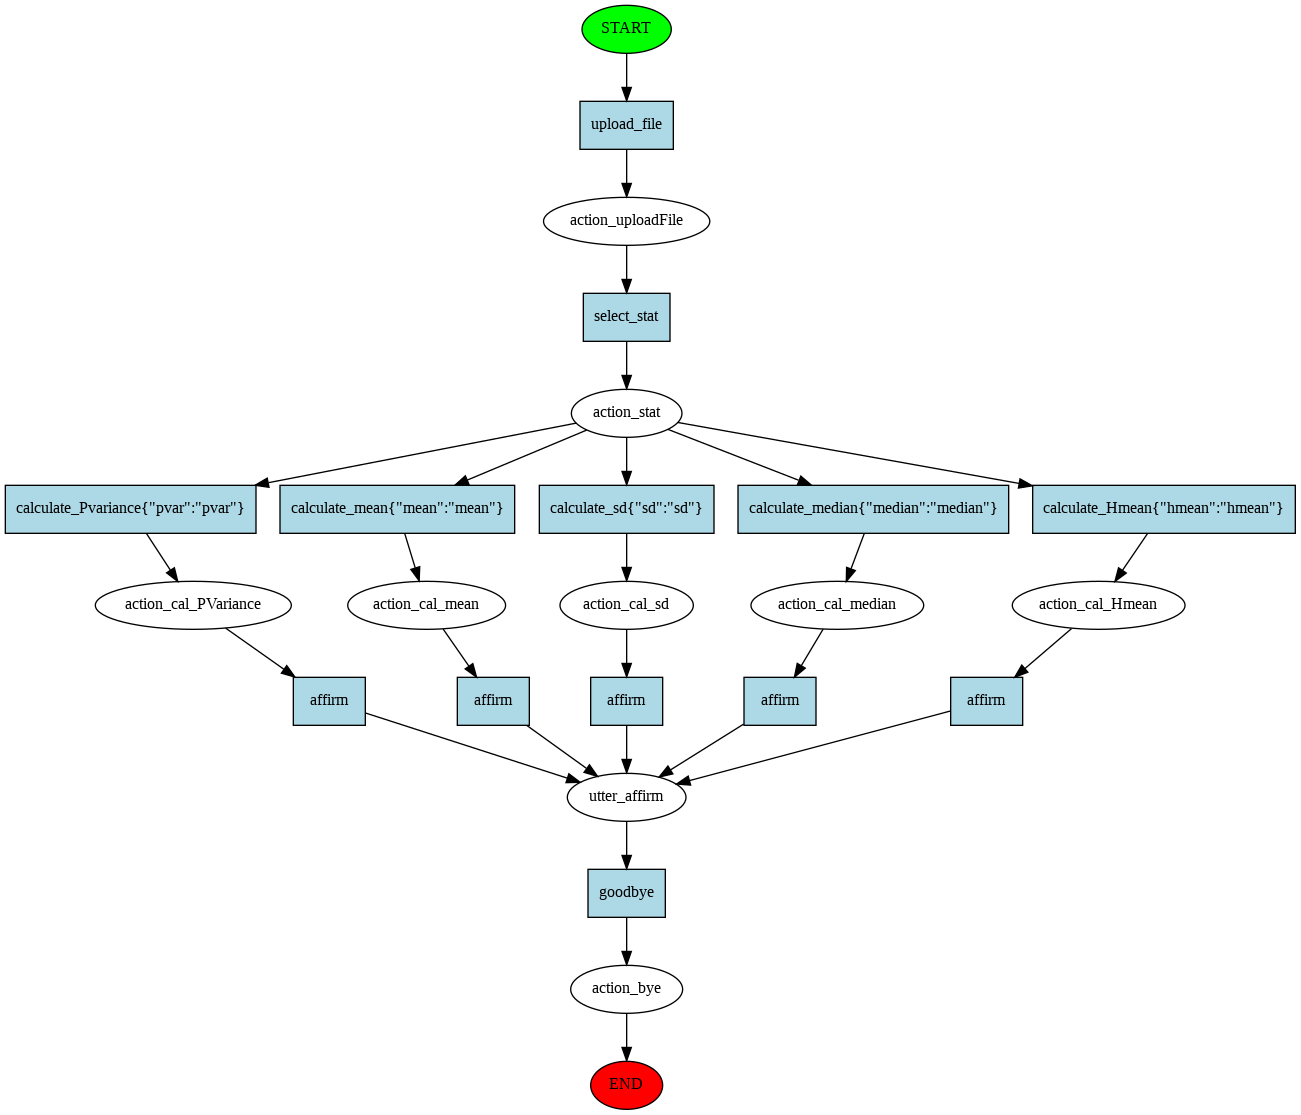

In [0]:
#from IPython.display import Image
from rasa_core.agent import Agent
from IPython.core.display import Image, display

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=10)
Image(filename="story_graph.png")

## References

1.   "Understand The Mapping Between Intents, Slots And Actions". Rasa Community Forum, 2019, https://forum.rasa.com/t/understand-the-mapping-between-intents-slots-and-actions/1777.

2.   Build A Conversational Chatbot With Rasa Stack And Python— Rasa NLU". Medium, 2019, https://medium.com/@itsromiljain/build-a-conversational-chatbot-with-rasa-stack-and-python-rasa-nlu-b79dfbe59491.

3. "Conversational AI Chatbot Using Rasa NLU & Rasa Core: How Dialogue Handling With Rasa Core Can Use LSTM By Using Supervised And Reinforcement Learning Algorithm". Medium, 2019, https://medium.com/@BhashkarKunal/conversational-ai-chatbot-using-rasa-nlu-rasa-core-how-dialogue-handling-with-rasa-core-can-use-331e7024f733.

4. "Rasa Tutorial". Rasa.Com, 2019, https://rasa.com/docs/rasa/user-guide/rasa-tutorial/.

